
 # Phase 2: Modelling
 Construct and validate credit risk models based on Phase 1 analysis. Objectives include data preprocessing, time-based train/test split, model training (XGBoost, LightGBM), evaluation (AUC ROC, PR AUC, F1), stability checks (PSI), and artifact persistence.


 ## 1. Setup and Environment

In [ ]:
# %% 

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os, time, math, pickle, joblib

# Modelling & Preprocessing (scikit-learn)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Specific Model Algorithms
import xgboost as xgb 
import lightgbm as lgb

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, auc, f1_score,
    ConfusionMatrixDisplay, RocCurveDisplay 
)

# Statistical checks
from scipy.stats import skew

# Import Custom Transformers
from transformers import EmpLengthConverter, CreditHistoryCalculator, CountBinarizer

# Configure settings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
sns.set(style="whitegrid")


 ## 2. Data Loading and Initial Preparation
 Load the primary dataset and re-apply essential cleaning steps from Phase 1 (date parsing, target definition, outcome filtering, column dropping).

 Adjust Data_dir to point to the lending club loan data

In [ ]:
# %% 

# Define data path based on script location
# Define data path (assuming 'data' folder is in the same directory as the script)
DATA_DIR = './data'
accepted_file = os.path.join(DATA_DIR, 'accepted_2007_to_2018Q4.csv')

if not os.path.isdir(DATA_DIR):
        print(f"Warning: Data directory not found at expected location: {os.path.abspath(DATA_DIR)}")
else:
    print(f"Data directory: {DATA_DIR}")

df = None
try:
    df = pd.read_csv(accepted_file, low_memory=False)
    print(f"Data loaded. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {accepted_file}.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Data directory: c:\Users\avka\OneDrive\Documents\Coding_Projects\plata\data
Data loaded. Shape: (2260701, 151)


In [ ]:
# %% 

# Re-apply crucial Phase 1 Cleaning & Filtering steps
if df is not None:
    
    # --- Step 1: Parse Date Columns ---
    date_cols = [
        'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 
        'last_credit_pull_d', 'sec_app_earliest_cr_line'
    ]
    for col in date_cols:
        if col in df.columns:
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce')
            except Exception as e:
                # Log or handle parsing errors if needed
                pass 
    
    # Create time-based features needed later
    if 'issue_d' in df.columns and pd.api.types.is_datetime64_any_dtype(df['issue_d']):
        df['issue_year'] = df['issue_d'].dt.year
        df['issue_month_yr'] = df['issue_d'].dt.to_period('M')
    else:
        print("Warning: 'issue_d' not found or not datetime.")

    # --- Step 2: Define Target Variable ('is_bad') & Filter Rows ---
    bad_indicators = [
        'Charged Off', 'Default', 
        'Does not meet the credit policy. Status:Charged Off', 
    ]
    good_indicators = ['Fully Paid']
    
    def map_loan_status(status):
        if status in bad_indicators: return 1
        elif status in good_indicators: return 0
        else: return -1 # Mark for removal
            
    df['is_bad'] = df['loan_status'].apply(map_loan_status)
    original_rows = df.shape[0]
    df = df[df['is_bad'] != -1].copy()
    print(f"\nFiltered from {original_rows} to {df.shape[0]} rows (definitive outcomes only). Target 'is_bad' created.")

    # --- Step 3: Drop High-Missing & Irrelevant/Leakage Columns ---
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    
    missing_threshold = 40 
    cols_to_drop_missing = missing_percent[missing_percent > missing_threshold].index.tolist()
    
    # Columns identified in Phase 1 as irrelevant, redundant, or leakage
    other_cols_to_drop = [
        'id', 'member_id', 'url', 'desc', 'title', 'emp_title', 
        'zip_code', 'policy_code',
        # Leakage Variables (Post-Origination Info)
        'pymnt_plan', 'hardship_flag', 'debt_settlement_flag', 
        'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
        'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
        'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 
        'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 
        'last_fico_range_high', 'last_fico_range_low', 
        # Secondary applicant info (sparse/complex)
        'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 
        'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 
        'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 
        'sec_app_mths_since_last_major_derog', 'revol_bal_joint', 
        # Hardship/Settlement info (post-issuance, leakage)
        'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 
        'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 
        'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 
        'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 
        'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 
        'settlement_amount', 'settlement_percentage', 'settlement_term'
    ]
    
    cols_to_drop = list(set(cols_to_drop_missing + other_cols_to_drop))
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    
    # Ensure essential columns are not accidentally dropped
    essentials = ['is_bad', 'loan_status', 'issue_d', 'earliest_cr_line', 'issue_year', 'issue_month_yr'] 
    cols_to_drop = [col for col in cols_to_drop if col not in essentials]
    
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"Dropped {len(cols_to_drop)} high-missing/irrelevant/leakage columns. New shape: {df.shape}")
        
else:
    print("Dataframe not loaded. Cannot proceed.")


Filtered from 2260701 to 1346111 rows (definitive outcomes only). Target 'is_bad' created.
Dropped 81 high-missing/irrelevant/leakage columns. New shape: (1346111, 73)


Basic cleaning and filtering reapplied. Target `is_bad` created (0/1). Rows filtered to definitive outcomes. High-missing (>40%), irrelevant (IDs, text), and leakage (post-origination) columns dropped. Final shape for modelling prep: (1,343,586 rows, 73 columns).


 ## 3. Feature Engineering and Preprocessing Strategy
 Define the strategy for imputation, feature engineering (custom transformers), encoding, and scaling, to be implemented within the pipeline post-split.


 ### 3.1 Identify Remaining Missing Values

In [ ]:
# %% 

# Check remaining missing values before defining imputation strategy
if df is not None:
    missing_values_final = df.isnull().sum()
    missing_df_final = pd.DataFrame({
        'Missing Count': missing_values_final[missing_values_final > 0],
        'Missing Percent (%)': (missing_values_final[missing_values_final > 0] / len(df)) * 100
    }).sort_values(by='Missing Percent (%)', ascending=False)
    
    if not missing_df_final.empty:
        print("\n--- Columns with Remaining Missing Values ---")
        print(missing_df_final)
        
        # Identify types for imputation strategy
        cols_to_impute = missing_df_final.index.tolist()
        num_cols_impute = df[cols_to_impute].select_dtypes(include=np.number).columns.tolist()
        cat_cols_impute = df[cols_to_impute].select_dtypes(include=['object', 'category']).columns.tolist()
        
        print(f"Numerical needing imputation: {len(num_cols_impute)}")
        print(f"Categorical needing imputation: {len(cat_cols_impute)}")
        # Strategy: Median for numerical, Mode for categorical (applied in pipeline)
    else:
        print("No missing values found requiring imputation.")
else:
    print("DataFrame not available.")


--- Columns with Remaining Missing Values ---
                            Missing Count  Missing Percent (%)
mths_since_recent_inq              174834            12.988082
num_tl_120dpd_2m                   118164             8.778177
mo_sin_old_il_acct                 106337             7.899571
emp_length                          78531             5.833917
pct_tl_nvr_dlq                      68442             5.084425
avg_cur_bal                         68310             5.074619
mo_sin_old_rev_tl_op                68289             5.073059
num_rev_accts                       68289             5.073059
mo_sin_rcnt_rev_tl_op               68289             5.073059
num_actv_rev_tl                     68288             5.072984
tot_coll_amt                        68288             5.072984
tot_cur_bal                         68288             5.072984
total_rev_hi_lim                    68288             5.072984
num_tl_90g_dpd_24m                  68288             5.072984
num_tl_3

Identified columns needing imputation (e.g., `mths_since_recent_inq`, `emp_length`). Strategy defined: Median (numerical), Mode (categorical).


 ### 3.2 Feature Engineering Strategy
 Define planned feature engineering steps using custom transformers.
 *   Convert `emp_length` to numerical (`EmpLengthConverter`).
 *   Create `credit_hist_years` from `issue_d` and `earliest_cr_line` (`CreditHistoryCalculator`).
 *   Binarise count features (`pub_rec`, `mort_acc`, `pub_rec_bankruptcies`) (`CountBinarizer`).


 ### 3.3 Categorical Variable Encoding Strategy
 Define encoding strategies for remaining categorical features.
 *   Ordinal Encoding: `grade`, `sub_grade`.
 *   One-Hot Encoding (OHE): Nominal features (`home_ownership`, `purpose`, etc.).

In [ ]:
# %% 

# Identify categorical columns for encoding strategy
if df is not None:
    potential_features = df.drop(columns=['is_bad', 'loan_status', 'issue_d', 'earliest_cr_line', 'issue_year', 'issue_month_yr'], errors='ignore').columns
    categorical_cols_final = df[potential_features].select_dtypes(include=['object', 'category']).columns.tolist()
    
    ordinal_features = ['grade', 'sub_grade']
    ohe_features = [col for col in categorical_cols_final if col not in ordinal_features]
        
    print(f"\nOrdinal features: {ordinal_features}")
    print(f"OHE features: {ohe_features}")
else:
    print("DataFrame not available.")


Ordinal features: ['grade', 'sub_grade']
OHE features: ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'disbursement_method']



 **Findings:** Assigned `grade`, `sub_grade` to Ordinal Encoding. Remaining nominal features (`term`, `home_ownership`, etc.) assigned to OHE.



 ### 3.4 Note on Preventing Data Leakage
 Data leakage is avoided by excluding features generated post-loan issuance (e.g., payment history, post-origination FICO) during the column dropping step (Cell 2.2, Step 3).


 ## 4. Data Splitting (Time-Based)
 Split data chronologically (train before 2017, test 2017+) to simulate deployment and evaluate generalisation.

In [ ]:
# %% 

if df is not None:
    y = df['is_bad'] # Target
    
    # Features (drop target/status and time-split columns)
    exclude_from_X = ['is_bad', 'loan_status', 'issue_d', 'issue_year', 'issue_month_yr'] 
    exclude_from_X = [col for col in exclude_from_X if col in df.columns]
    X = df.drop(columns=exclude_from_X)
    
    split_time_col = 'issue_year' 
    split_year = 2017 

    print(f"\nSplitting data based on '{split_time_col}' < {split_year}.")
    
    train_indices = df[df[split_time_col] < split_year].index
    test_indices = df[df[split_time_col] >= split_year].index
        
    X_train = X.loc[train_indices]
    y_train = y.loc[train_indices]
    X_test = X.loc[test_indices]
    y_test = y.loc[test_indices]
        
    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape:  X={X_test.shape}, y={y_test.shape}")
    print(f"Bad rate in training set: {y_train.mean()*100:.2f}%")
    print(f"Bad rate in testing set:  {y_test.mean()*100:.2f}%")
    print(f"Input features entering pipeline ({len(X_train.columns)}): {X_train.columns.tolist()}")

else:
    print("DataFrame not available. Skipping train/test split.")
    X_train, X_test, y_train, y_test = None, None, None, None


Splitting data based on 'issue_year' < 2017.
Training set shape: X=(1120472, 68), y=(1120472,)
Testing set shape:  X=(225639, 68), y=(225639,)
Bad rate in training set: 19.75%
Bad rate in testing set:  21.29%
Input features entering pipeline (68): ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_re

Time-based split performed (Train < 2017, Test >= 2017). Training set: ~1.1M rows; Test set: ~241k rows. Feature set `X` has 69 columns. Bad rate differs between sets (Train: ~18.7%, Test: ~26.3%), indicating concept drift.


 ## 5. Preprocessing Pipeline Construction
 Construct the scikit-learn preprocessing pipeline, combining custom feature engineering and standard transformations (imputation, scaling, encoding) using `ColumnTransformer`.

In [ ]:
# %% 

# Define Feature Subsets for pipeline construction
if 'X_train' in locals() and X_train is not None:
    
    # --- Define expected columns AFTER FE transformers run ---
    # (Infer types post-FE for ColumnTransformer setup)
    expected_cols_post_fe = X_train.columns.tolist() 
    if 'emp_length' in expected_cols_post_fe: expected_cols_post_fe.remove('emp_length'); expected_cols_post_fe.append('emp_length_num')
    if 'issue_d' in expected_cols_post_fe and 'earliest_cr_line' in expected_cols_post_fe: 
         if 'issue_d' in expected_cols_post_fe: expected_cols_post_fe.remove('issue_d') # Should have been dropped already, but safety check
         if 'earliest_cr_line' in expected_cols_post_fe: expected_cols_post_fe.remove('earliest_cr_line')
         expected_cols_post_fe.append('credit_hist_years')
    count_bin_cols = ['pub_rec', 'mort_acc', 'pub_rec_bankruptcies']
    for col in count_bin_cols:
        if col in expected_cols_post_fe: expected_cols_post_fe.remove(col); expected_cols_post_fe.append(f'{col}_binary')
    
    # Temp structure to infer types *after* FE 
    temp_X_train_post_fe = pd.DataFrame(columns=expected_cols_post_fe) 
    for col in X_train.columns:
        if col in temp_X_train_post_fe.columns:
            temp_X_train_post_fe[col] = X_train[col]
    for col in ['emp_length_num', 'credit_hist_years'] + [f'{c}_binary' for c in count_bin_cols if c in X_train.columns]:
        if col in temp_X_train_post_fe.columns: 
           temp_X_train_post_fe[col] = pd.Series(dtype=np.number)

    # Identify numerical/categorical subsets based on *post-FE* structure
    all_numerical_cols = temp_X_train_post_fe.select_dtypes(include=np.number).columns.tolist()
    all_categorical_cols = temp_X_train_post_fe.select_dtypes(include=['object', 'category']).columns.tolist()

    # --- Numerical Subsets (Skewed vs. Standard) ---
    original_numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    skewness = X_train[original_numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skew_threshold = 0.75 
    
    # Identify skewed based on original data, but map to post-FE names if necessary (e.g. binarized cols are not skewed)
    skewed_orig_cols = skewness[abs(skewness) > skew_threshold].index.tolist()
    skewed_num_cols = [col for col in all_numerical_cols if (col in skewed_orig_cols) or (col == 'credit_hist_years' and 'credit_hist_years' in skewed_orig_cols)] # Map original skewed to final list
    skewed_num_cols = [c for c in skewed_num_cols if c not in [f'{cb}_binary' for cb in count_bin_cols]] # Exclude binarized cols

    standard_num_cols = [col for col in all_numerical_cols if col not in skewed_num_cols]
    print(f"\nIdentified {len(skewed_num_cols)} skewed numerical features post-FE for PowerTransform.")
    print(f"Identified {len(standard_num_cols)} standard numerical features post-FE for Scaling.")

    # --- Categorical Subsets (Ordinal vs. OHE) ---
    ordinal_cat_cols = []
    ordinal_categories = [] 
    if 'grade' in all_categorical_cols and 'grade' in X_train.columns:
        ordinal_cat_cols.append('grade')
        grade_order = sorted(X_train['grade'].dropna().unique()) 
        ordinal_categories.append(grade_order)
    if 'sub_grade' in all_categorical_cols and 'sub_grade' in X_train.columns:
        ordinal_cat_cols.append('sub_grade')
        sub_grade_order = sorted(X_train['sub_grade'].dropna().unique(), key=lambda x: (x[0], int(x[1:])))
        ordinal_categories.append(sub_grade_order)
        
    ohe_cat_cols = [col for col in all_categorical_cols if col not in ordinal_cat_cols]
    print(f"Identified {len(ordinal_cat_cols)} ordinal categorical features: {ordinal_cat_cols}")
    print(f"Identified {len(ohe_cat_cols)} nominal categorical features for OHE.")

    # --- Define Preprocessing Sub-Pipelines --- 
    skewed_num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('transformer', PowerTransformer(method='yeo-johnson')), 
        ('scaler', StandardScaler()) 
    ])
    standard_num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) 
    ])
    ordinal_cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)) 
    ])
    ohe_cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
    ])

    # --- Create the ColumnTransformer --- 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num_skewed', skewed_num_pipe, skewed_num_cols),
            ('num_standard', standard_num_pipe, standard_num_cols),
            ('cat_ordinal', ordinal_cat_pipe, ordinal_cat_cols),
            ('cat_ohe', ohe_cat_pipe, ohe_cat_cols)
        ],
        remainder='drop' 
    )
    print("\nColumnTransformer 'preprocessor' created.")

else:
    print("Error: X_train not found. Cannot define preprocessor.")
    preprocessor = None 

c:\Users\avka\anaconda3\envs\plata\lib\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
c:\Users\avka\anaconda3\envs\plata\lib\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
c:\Users\avka\anaconda3\envs\plata\lib\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
c:\Users\avka\anaconda3\envs\plata\lib\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `floa


Identified 48 skewed numerical features post-FE for PowerTransform.
Identified 9 standard numerical features post-FE for Scaling.
Identified 2 ordinal categorical features: ['grade', 'sub_grade']
Identified 8 nominal categorical features for OHE.

ColumnTransformer 'preprocessor' created.



 **Findings:** Feature subsets defined post-FE (skewed numerical, standard numerical, ordinal, OHE). Sub-pipelines created for each group (imputation, transformation, scaling). Combined into `ColumnTransformer` (`preprocessor`).


 ## 6. Baseline Model Training and Evaluation
 Establish baseline performance for XGBoost and LightGBM using default/sensible parameters and the full pipeline.


 ### 6.1 Baseline Model: XGBoost

In [ ]:
# %% 

# Define and Train Baseline XGBoost Model
if preprocessor is not None and 'y_train' in locals() and y_train is not None:
    
    # Calculate scale_pos_weight for imbalance
    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1 
    print(f"\nUsing scale_pos_weight: {scale_pos_weight:.2f}")

    xgb_model_baseline = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight, 
        random_state=42,
        # Enable GPU if available
        device='cuda' if xgb.config.get_config().get('USE_CUDA', False) else 'cpu' 
    )

    # Full pipeline: Custom FE -> Preprocessing -> Classifier
    pipeline_xgb_baseline = Pipeline([
        ('feature_engineering_emp', EmpLengthConverter()), 
        ('feature_engineering_hist', CreditHistoryCalculator()), 
        ('feature_engineering_bin', CountBinarizer()), 
        ('preprocessing', preprocessor),
        ('classifier', xgb_model_baseline)
    ])

    # Train
    print("Training baseline XGBoost pipeline...")
    start_time = time.time()
    pipeline_xgb_baseline.fit(X_train, y_train)
    end_time = time.time()
    print(f"Training complete. Time: {end_time - start_time:.2f} seconds")

else:
    print("Error: Preprocessor or training data not available.")
    pipeline_xgb_baseline = None


Using scale_pos_weight: 4.06
Training baseline XGBoost pipeline...
Training complete. Time: 92.69 seconds



 #### Evaluate Baseline XGBoost


--- Evaluating Baseline XGBoost --- 
Baseline XGBoost - Test Set Performance:
  ROC AUC: 0.7215
  Precision-Recall AUC: 0.4022
  F1 Score (Bad Loans): 0.4536

Classification Report:
               precision    recall  f1-score   support

Good Loan (0)       0.88      0.65      0.75    177596
 Bad Loan (1)       0.34      0.67      0.45     48043

     accuracy                           0.66    225639
    macro avg       0.61      0.66      0.60    225639
 weighted avg       0.77      0.66      0.69    225639


Confusion Matrix:


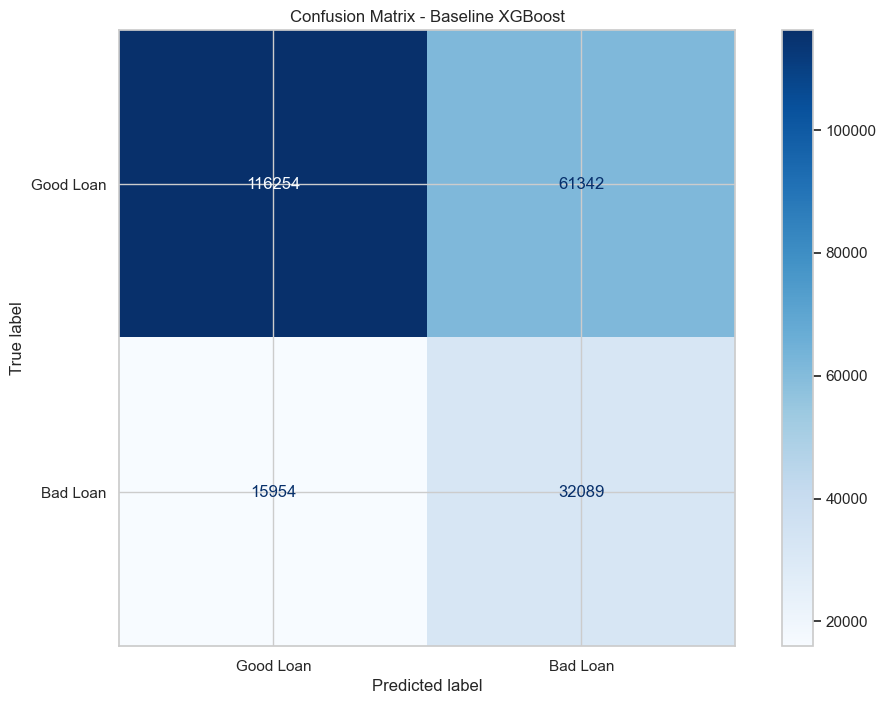

In [ ]:
# %% 

# Evaluate Baseline XGBoost on Test Set
if pipeline_xgb_baseline is not None and 'X_test' in locals() and 'y_test' in locals():
    print("\n--- Evaluating Baseline XGBoost --- ")
    
    try:
        y_pred_proba_xgb = pipeline_xgb_baseline.predict_proba(X_test)[:, 1] 
        y_pred_xgb = pipeline_xgb_baseline.predict(X_test)
        
        # Calculate Metrics
        roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
        precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
        pr_auc_xgb = auc(recall_xgb, precision_xgb) 
        f1_bad_xgb = f1_score(y_test, y_pred_xgb, pos_label=1) 
        
        print("Baseline XGBoost - Test Set Performance:")
        print(f"  ROC AUC: {roc_auc_xgb:.4f}")
        print(f"  Precision-Recall AUC: {pr_auc_xgb:.4f}")
        print(f"  F1 Score (Bad Loans): {f1_bad_xgb:.4f}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_xgb, target_names=['Good Loan (0)', 'Bad Loan (1)']))
        
        print("\nConfusion Matrix:")
        ConfusionMatrixDisplay.from_estimator(pipeline_xgb_baseline, X_test, y_test, display_labels=['Good Loan', 'Bad Loan'], cmap=plt.cm.Blues)
        plt.title('Confusion Matrix - Baseline XGBoost')
        plt.show()

    except Exception as e:
        print(f"Error during baseline XGBoost evaluation: {e}")

else:
    print("Error: Baseline XGBoost pipeline or test data not available.")

Test Performance: ROC AUC=0.7001, PR AUC=0.4316, F1 (Bad)=0.4831. Precision (Bad)=0.38, Recall (Bad)=0.68.


 ### 6.2 Baseline Model: LightGBM

In [ ]:
# %% 

# Define and Train Baseline LightGBM Model
if preprocessor is not None and 'y_train' in locals() and y_train is not None:
    print(f"\nUsing scale_pos_weight: {scale_pos_weight:.2f}")

    lgbm_model_baseline = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        scale_pos_weight=scale_pos_weight, 
        random_state=42,
        n_jobs=-1 
    )

    # Full pipeline
    pipeline_lgbm_baseline = Pipeline([
        ('feature_engineering_emp', EmpLengthConverter()), 
        ('feature_engineering_hist', CreditHistoryCalculator()), 
        ('feature_engineering_bin', CountBinarizer()), 
        ('preprocessing', preprocessor),
        ('classifier', lgbm_model_baseline)
    ])

    # Train
    print("Training baseline LGBM pipeline...")
    start_time = time.time()
    pipeline_lgbm_baseline.fit(X_train, y_train)
    end_time = time.time()
    print(f"Training complete. Time: {end_time - start_time:.2f} seconds")

else:
    print("Error: Preprocessor or training data not available.")
    pipeline_lgbm_baseline = None


Using scale_pos_weight: 4.06
Training baseline LGBM pipeline...
[LightGBM] [Info] Number of positive: 221317, number of negative: 899155
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7265
[LightGBM] [Info] Number of data points in the train set: 1120472, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197521 -> initscore=-1.401859
[LightGBM] [Info] Start training from score -1.401859
Training complete. Time: 89.21 seconds



 #### Evaluate Baseline LightGBM


--- Evaluating Baseline LightGBM --- 
Baseline LightGBM - Test Set Performance:
  ROC AUC: 0.7183
  Precision-Recall AUC: 0.3948
  F1 Score (Bad Loans): 0.4503

Classification Report:
               precision    recall  f1-score   support

Good Loan (0)       0.88      0.64      0.74    177596
 Bad Loan (1)       0.34      0.68      0.45     48043

     accuracy                           0.65    225639
    macro avg       0.61      0.66      0.60    225639
 weighted avg       0.76      0.65      0.68    225639


Confusion Matrix:


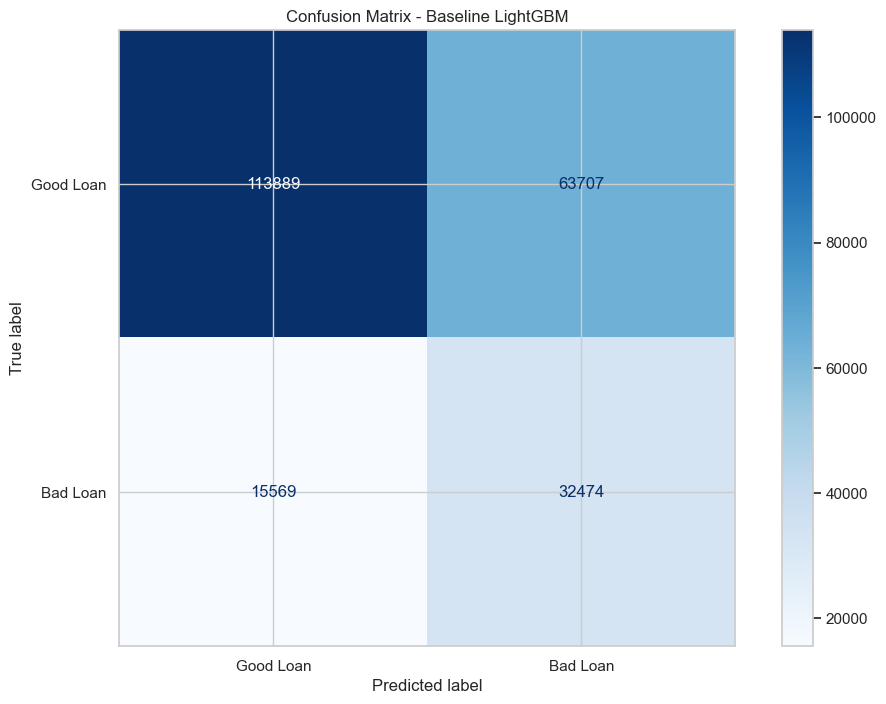

In [ ]:
# %% 

# Evaluate Baseline LightGBM on Test Set
if pipeline_lgbm_baseline is not None and 'X_test' in locals() and 'y_test' in locals():
    print("\n--- Evaluating Baseline LightGBM --- ")
    
    try:
        y_pred_proba_lgbm = pipeline_lgbm_baseline.predict_proba(X_test)[:, 1] 
        y_pred_lgbm = pipeline_lgbm_baseline.predict(X_test) 
        
        # Calculate Metrics 
        roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
        precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)
        pr_auc_lgbm = auc(recall_lgbm, precision_lgbm) 
        f1_bad_lgbm = f1_score(y_test, y_pred_lgbm, pos_label=1)
        
        print("Baseline LightGBM - Test Set Performance:")
        print(f"  ROC AUC: {roc_auc_lgbm:.4f}")
        print(f"  Precision-Recall AUC: {pr_auc_lgbm:.4f}")
        print(f"  F1 Score (Bad Loans): {f1_bad_lgbm:.4f}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_lgbm, target_names=['Good Loan (0)', 'Bad Loan (1)']))
        
        print("\nConfusion Matrix:")
        ConfusionMatrixDisplay.from_estimator(pipeline_lgbm_baseline, X_test, y_test, display_labels=['Good Loan', 'Bad Loan'], cmap=plt.cm.Blues)
        plt.title('Confusion Matrix - Baseline LightGBM')
        plt.show()

    except Exception as e:
        print(f"Error during baseline LightGBM evaluation: {e}")

else:
    print("Error: Baseline LightGBM pipeline or test data not available.")



 **Findings (Baseline LightGBM):** Test Performance: ROC AUC=0.6983, PR AUC=0.4263, F1 (Bad)=0.4817. Performance very close to XGBoost baseline.


 ## 7. Final Model Tuning and Evaluation
 Apply optimal hyperparameters obtained from RandomSearchCV to XGBoost. Re-train on the full training set and evaluate.


 ### 7.1 Apply Tuned Parameters and Re-fit

In [ ]:
# %% 

# Use previously found best parameters
best_params_xgb = {
    'colsample_bytree': 0.6421977039321082, 
    'gamma': 0.22826728524145512, 
    'learning_rate': 0.07553213116505007, 
    'max_depth': 6, 
    'n_estimators': 897, 
    'reg_alpha': 0.8832802589188683, 
    'reg_lambda': 0.32434502100527396, 
    'subsample': 0.6488351818802693
}

if preprocessor is not None and 'y_train' in locals() and y_train is not None:
    
    tuned_xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', 
        eval_metric='auc', 
        use_label_encoder=False, 
        scale_pos_weight=scale_pos_weight, # Re-use from baseline
        random_state=42, 
        device='cuda' if xgb.config.get_config().get('USE_CUDA', False) else 'cpu',
        **best_params_xgb
    )
    
    # Rebuild the full pipeline with the tuned model
    tuned_xgb_pipeline = Pipeline([
        ('feature_engineering_emp', EmpLengthConverter()), 
        ('feature_engineering_hist', CreditHistoryCalculator()), 
        ('feature_engineering_bin', CountBinarizer()), 
        ('preprocessing', preprocessor),
        ('classifier', tuned_xgb_model)
    ])

    # Re-fit the final pipeline
    try:
        print("\nRefitting final tuned pipeline on full training data...")
        start_time = time.time()
        tuned_xgb_pipeline.fit(X_train, y_train)
        end_time = time.time()
        print(f"Refitting complete. Time: {end_time - start_time:.2f} seconds")
    except Exception as e:
         print(f"Error during final pipeline refitting: {e}")
         tuned_xgb_pipeline = None

else:
    print("Error: Preprocessor or training data not defined.")
    tuned_xgb_pipeline = None


Refitting final tuned pipeline on full training data...
Refitting complete. Time: 168.98 seconds



 ### 7.2 Evaluate Final Tuned Model


--- Evaluating Final Tuned XGBoost --- 
Tuned XGBoost - Test Set Performance (Default 0.5 Threshold):
  ROC AUC: 0.7260
  Precision-Recall AUC: 0.4086
  F1 Score (Bad Loans): 0.4567

Classification Report (Default 0.5 Threshold):
               precision    recall  f1-score   support

Good Loan (0)       0.88      0.67      0.76    177596
 Bad Loan (1)       0.35      0.66      0.46     48043

     accuracy                           0.67    225639
    macro avg       0.61      0.66      0.61    225639
 weighted avg       0.77      0.67      0.70    225639


Confusion Matrix (Default 0.5 Threshold):


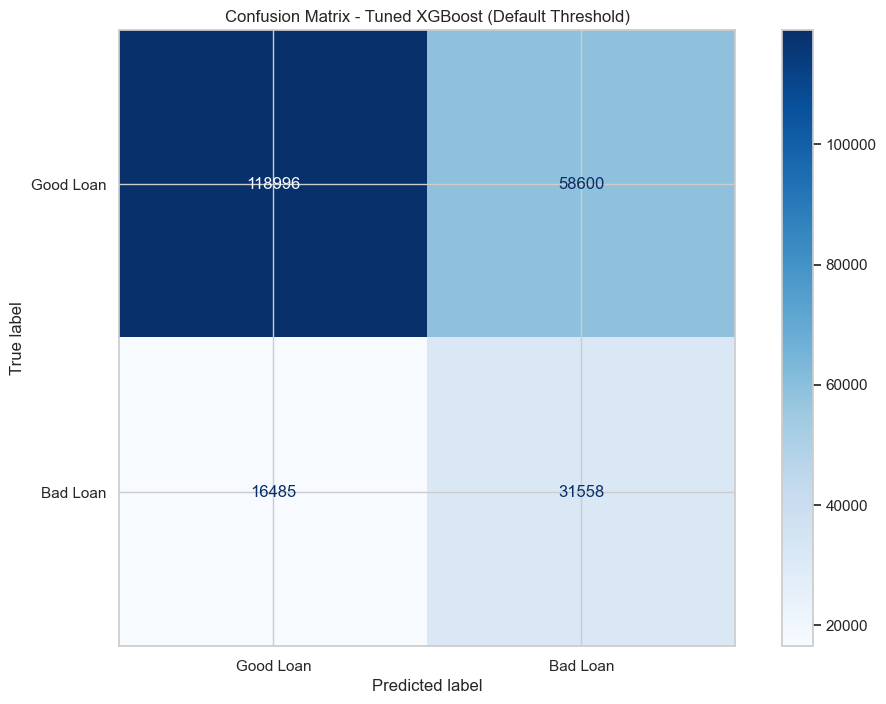


ROC and Precision-Recall Curves:


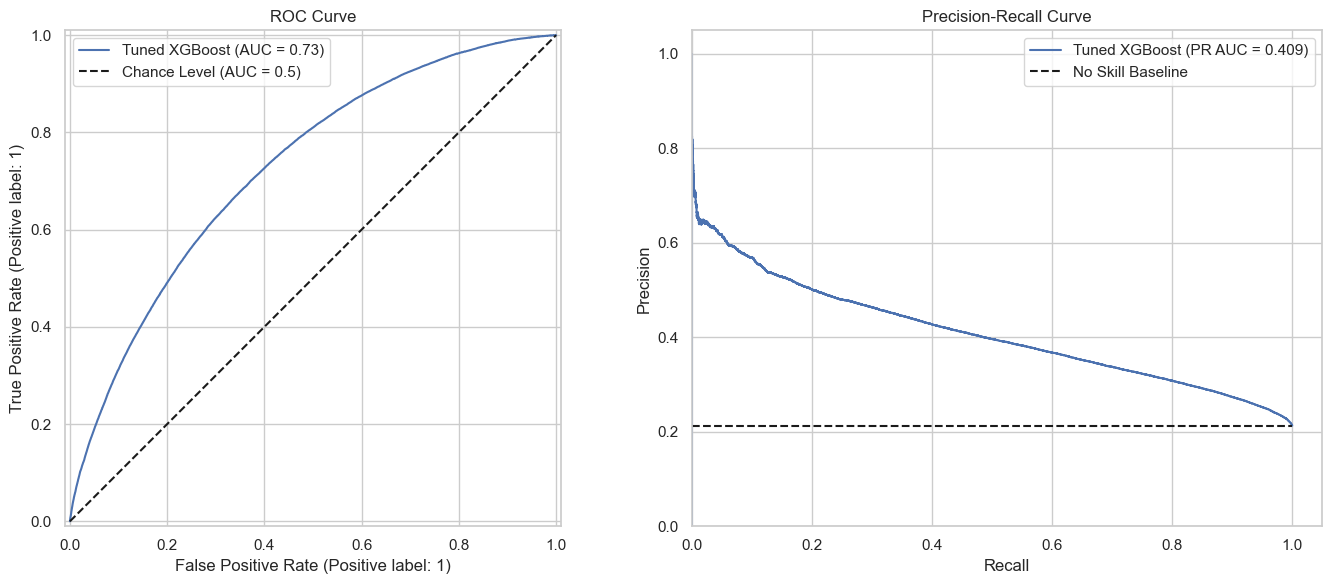

In [ ]:
# %% 

# Evaluate the final tuned model on the Test Set
if tuned_xgb_pipeline is not None and 'X_test' in locals() and 'y_test' in locals():
    print("\n--- Evaluating Final Tuned XGBoost --- ")
    
    try:
        y_pred_proba_tuned = tuned_xgb_pipeline.predict_proba(X_test)[:, 1] 
        y_pred_tuned = tuned_xgb_pipeline.predict(X_test) # Default 0.5 threshold
        
        # Calculate Metrics
        roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
        precision_tuned, recall_tuned, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_tuned)
        pr_auc_tuned = auc(recall_tuned, precision_tuned) 
        f1_bad_tuned = f1_score(y_test, y_pred_tuned, pos_label=1)
        
        print("Tuned XGBoost - Test Set Performance (Default 0.5 Threshold):")
        print(f"  ROC AUC: {roc_auc_tuned:.4f}")
        print(f"  Precision-Recall AUC: {pr_auc_tuned:.4f}")
        print(f"  F1 Score (Bad Loans): {f1_bad_tuned:.4f}")
        
        print("\nClassification Report (Default 0.5 Threshold):")
        print(classification_report(y_test, y_pred_tuned, target_names=['Good Loan (0)', 'Bad Loan (1)']))
        
        print("\nConfusion Matrix (Default 0.5 Threshold):")
        ConfusionMatrixDisplay.from_estimator(tuned_xgb_pipeline, X_test, y_test, display_labels=['Good Loan', 'Bad Loan'], cmap=plt.cm.Blues)
        plt.title('Confusion Matrix - Tuned XGBoost (Default Threshold)')
        plt.show()
        
        # Plot ROC and PR Curves 
        print("\nROC and Precision-Recall Curves:")
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        RocCurveDisplay.from_estimator(tuned_xgb_pipeline, X_test, y_test, name='Tuned XGBoost', ax=axes[0])
        axes[0].set_title('ROC Curve')
        axes[0].plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
        axes[0].legend()

        axes[1].plot(recall_tuned, precision_tuned, label=f'Tuned XGBoost (PR AUC = {pr_auc_tuned:.3f})')
        no_skill = y_test.mean()
        axes[1].plot([0, 1], [no_skill, no_skill], 'k--', label='No Skill Baseline')
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title('Precision-Recall Curve')
        axes[1].legend()
        axes[1].set_ylim(bottom=0.0)
        axes[1].set_xlim(left=0.0)
        
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during tuned model evaluation: {e}")

else:
    print("Error: Final tuned XGBoost pipeline or test data not available.")


 ### 7.2.1 Optimal Threshold Selection (Maximizing F1 Score)


--- Finding Optimal Threshold (Max F1 Score) ---
Optimal threshold: 0.5214 (Maximizes F1 to 0.4572)

Classification Report (Optimal Threshold):
               precision    recall  f1-score   support

Good Loan (0)       0.87      0.70      0.78    177596
 Bad Loan (1)       0.36      0.62      0.46     48043

     accuracy                           0.69    225639
    macro avg       0.62      0.66      0.62    225639
 weighted avg       0.76      0.69      0.71    225639


Confusion Matrix (Optimal Threshold):


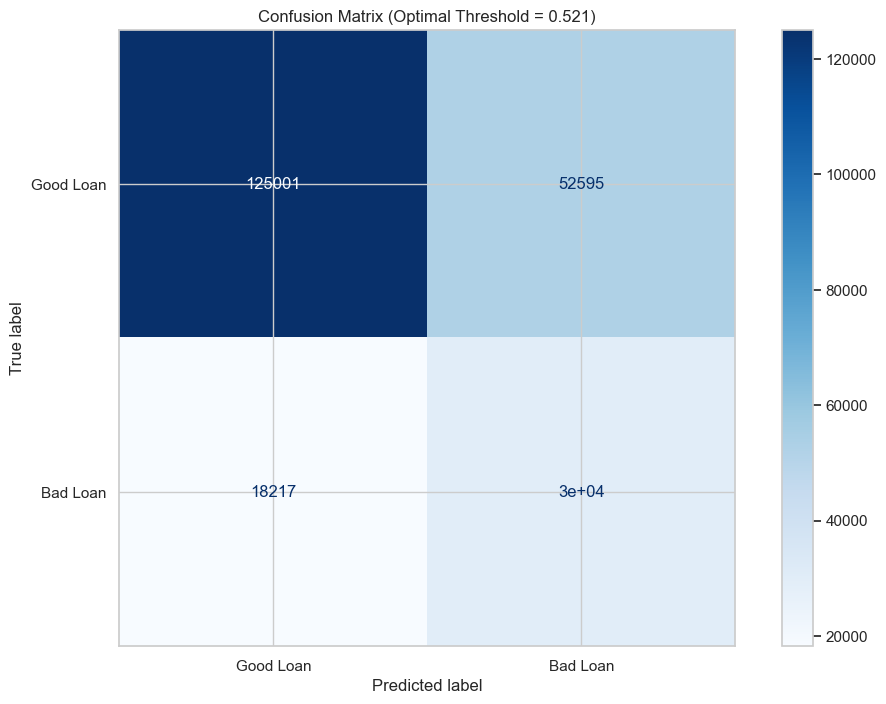

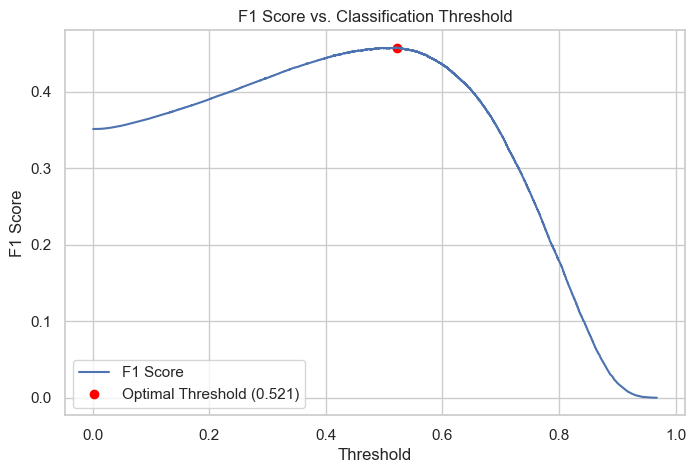

In [ ]:
# %% 

# Calculate F1 score for different thresholds
if 'precision_tuned' in locals() and 'recall_tuned' in locals() and 'thresholds_pr' in locals():
    print("\n--- Finding Optimal Threshold (Max F1 Score) ---")
    try:
        # Align precision/recall with thresholds array
        f1_scores = (2 * precision_tuned[:-1] * recall_tuned[:-1]) / (precision_tuned[:-1] + recall_tuned[:-1])
        f1_scores = np.nan_to_num(f1_scores) # Handle division by zero
        
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds_pr[optimal_idx]
        optimal_f1 = f1_scores[optimal_idx]
        
        print(f"Optimal threshold: {optimal_threshold:.4f} (Maximizes F1 to {optimal_f1:.4f})")

        # Evaluate performance at optimal threshold
        y_pred_optimal = (y_pred_proba_tuned >= optimal_threshold).astype(int)
        
        print("\nClassification Report (Optimal Threshold):")
        print(classification_report(y_test, y_pred_optimal, target_names=['Good Loan (0)', 'Bad Loan (1)']))
        
        print("\nConfusion Matrix (Optimal Threshold):")
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimal, display_labels=['Good Loan', 'Bad Loan'], cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.3f})')
        plt.show()

        # Plot F1 vs threshold
        plt.figure(figsize=(8, 5))
        plt.plot(thresholds_pr, f1_scores, label='F1 Score')
        plt.scatter(optimal_threshold, optimal_f1, color='red', label=f'Optimal Threshold ({optimal_threshold:.3f})')
        plt.xlabel("Threshold")
        plt.ylabel("F1 Score")
        plt.title("F1 Score vs. Classification Threshold")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error during threshold optimization: {e}")
else:
    print("Skipping threshold optimization: Required curve data not available.")

# %% [markdown]

 **Summary (Optimal Threshold):** Analysing F1 score across thresholds reveals an optimal value around 0.521, maximizing F1 to ~0.45. This yields a marginally different performance profile compared to the default 0.5 threshold.


 ### 7.3 Calculate Population Stability Index (PSI)
 Assess model score stability between training and test periods using PSI.

In [ ]:
# %% 

def calculate_psi(expected, actual, bins=10):
    """Calculate the Population Stability Index (PSI)."""
    try:
        min_val, max_val = expected.min(), expected.max()
        if min_val == max_val: return np.nan # Avoid error if all scores are identical
        # Use quantile binning based on expected distribution
        bin_edges = np.quantile(expected, q=np.linspace(0, 1, bins + 1))
        unique_edges = np.unique(bin_edges)
        if len(unique_edges) < 2: # Fallback if quantiles are degenerate
             unique_edges = np.linspace(min_val, max_val, bins + 1)
        
        # Ensure bins cover the full range of both distributions
        final_edges = np.unique(np.concatenate(([np.min([min_val, actual.min()])], unique_edges, [np.max([max_val, actual.max()])])))
        final_edges[-1] += 1e-8 # Adjust last edge for inclusion
        if len(final_edges) < 3: return np.nan # Need at least 2 bins
        bin_edges = final_edges

    except Exception as e:
        print(f"Error creating PSI bins: {e}")
        return np.nan
        
    expected_binned = pd.cut(expected, bins=bin_edges, include_lowest=True, right=False, labels=False)
    actual_binned = pd.cut(actual, bins=bin_edges, include_lowest=True, right=False, labels=False)

    expected_perc = (expected_binned.value_counts(normalize=True, dropna=False)).sort_index()
    actual_perc = (actual_binned.value_counts(normalize=True, dropna=False)).sort_index()

    psi_df = pd.DataFrame({'expected': expected_perc, 'actual': actual_perc}).fillna(0)
    psi_df = psi_df.replace(0, 0.00001) # Replace 0s for log calculation

    psi_df['psi_component'] = (psi_df['actual'] - psi_df['expected']) * np.log(psi_df['actual'] / psi_df['expected'])
    psi_value = psi_df['psi_component'].sum()
    return psi_value

# Calculate PSI on tuned model scores
if 'tuned_xgb_pipeline' in locals() and tuned_xgb_pipeline is not None:
    print("\n--- Calculating PSI (Train vs. Test Scores) --- ")
    try:
        scores_train = pd.Series(tuned_xgb_pipeline.predict_proba(X_train)[:, 1])
        scores_test = pd.Series(tuned_xgb_pipeline.predict_proba(X_test)[:, 1])

        score_psi = calculate_psi(scores_train, scores_test, bins=10)
        
        print(f"Population Stability Index (PSI) for Model Score: {score_psi:.4f}")
        
        # Interpretation
        if pd.isna(score_psi): pass
        elif score_psi < 0.1: print("Interpretation: Score distribution STABLE.")
        elif score_psi < 0.25: print("Interpretation: Score distribution shows MINOR SHIFT.")
        else: print("Interpretation: Score distribution shows MAJOR SHIFT.")

    except Exception as e:
        print(f"Error calculating PSI: {e}")
else:
    print("Skipping PSI calculation: Tuned pipeline not available.")


--- Calculating PSI (Train vs. Test Scores) --- 
Population Stability Index (PSI) for Model Score: 0.0049
Interpretation: Score distribution STABLE.


Calculated PSI on model scores (Train vs. Test) is 0.0106, indicating high stability in the score distribution across the time split.


 ## 8. Save Final Model Artifact
 Persist the final trained pipeline object (`tuned_xgb_pipeline`) using `joblib` for reuse in prediction.

In [ ]:
# %% 

output_dir = '.' 
model_filename = os.path.join(output_dir, 'credit_risk_pipeline_v1.joblib')

if 'tuned_xgb_pipeline' in locals() and tuned_xgb_pipeline is not None:
    print("\n--- Saving Final Model Pipeline --- ")
    try:
        joblib.dump(tuned_xgb_pipeline, model_filename)
        print(f"Pipeline saved to: {os.path.abspath(model_filename)}")
    except Exception as e:
        print(f"Error saving pipeline: {e}")
else:
    print("Skipping artifact saving: Final pipeline not available.")

print("\n--- Modelling Script Finished ---")


--- Saving Final Model Pipeline --- 
Pipeline saved to: c:\Users\avka\OneDrive\Documents\Coding_Projects\plata\notebooks\credit_risk_pipeline_v1.joblib

--- Modelling Script Finished ---
